# **MySQL Discussion**

# **Overall Discussion**

The "Empty Office" Analogy
"Before we can start querying data, we have to build the place where the data lives. Imagine Google Colab is an empty office we just rented for this hour.

* The OS (Linux): Is the building itself.

* This Code Block: Is the moving crew.

* It brings in the filing cabinets (MySQL Installation).

* It hires the clerk to manage the files (Service Start).

* It gives our Python script a security badge to enter the room (Authentication Fix)."

This tackles:

1. Provisioning: We allocate storage space.

2. Configuration: We set permissions and security.

3. Connectivity: We install drivers to talk to the database.

This cell converts our simple Python notebook into a full-stack Database Server.

In [1]:
# --- 1. INSTALLATION & CONFIGURATION (Run this once) ---
import os

# [Step 1: PREPARING THE SPACE]
# MySQL needs a specific directory to store 'lock files' (which prevent crashes).
# We manually create this folder and assign ownership to the 'mysql' user.
!mkdir -p /var/run/mysqld
!chown mysql:mysql /var/run/mysqld

# [Step 2: DOWNLOADING THE SOFTWARE]
# We use 'apt-get' (Linux App Store) to download the MySQL Server.
# The '> /dev/null' part is a "silencer"—it hides the messy installation text.
!apt-get update > /dev/null
!apt-get install -y mysql-server > /dev/null

# [Step 3: TURNING THE KEY]
# Just installing software doesn't run it. We must start the "Service" (Daemon).
# If this step is skipped, Python will see a "Connection Refused" error.
!service mysql start

# [Step 4: THE SECURITY FIX]
# Critical Step: By default, MySQL uses "Socket Auth" (only Linux root can login).
# Python is NOT Linux root. We must switch the security mode to 'mysql_native_password'
# so our script can log in with a standard password (which we set to empty '').
!mysql -u root -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY '';"
!mysql -u root -e "FLUSH PRIVILEGES;"

# [Step 5: THE TRANSLATOR]
# Python speaks "Objects"; MySQL speaks "Tables".
# This library translates between the two languages.
!pip install mysql-connector-python > /dev/null

print("✅ MySQL Server Installed, Configured, and Running!")

The syntax of the command is incorrect.
'chown' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
The system cannot find the path specified.
'service' is not recognized as an internal or external command,
operable program or batch file.
ERROR 2059 (HY000): Authentication plugin 'auth_gssapi_client' cannot be loaded: The specified module could not be found.


ERROR 2059 (HY000): Authentication plugin 'auth_gssapi_client' cannot be loaded: The specified module could not be found.




✅ MySQL Server Installed, Configured, and Running!


The system cannot find the path specified.


In [2]:
# --- 2. DATABASE SETUP & DATA POPULATION ---
import mysql.connector
import pandas as pd
from google.colab import data_table

# [Step 0: UI SETUP]
# This turns standard Pandas DataFrames into interactive, filterable tables (like Excel).
data_table.enable_dataframe_formatter()

# [Step 1: INITIAL CONNECTION]
# Note: We connect WITHOUT specifying a database initially.
# Why? Because 'sales_db' might not exist yet. We need to get in the door first.
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=""
)
cursor = conn.cursor()

# [Step 2: DATABASE CREATION]
# "IF NOT EXISTS" is crucial. It makes this cell "Idempotent" (safe to run multiple times).
cursor.execute("CREATE DATABASE IF NOT EXISTS sales_db")
print("✅ Database 'sales_db' ensured to exist.")

# [Step 3: CONTEXT SWITCH]
# Now we explicitly select the database we just created/found.
cursor.execute("USE sales_db")

# [Step 4: CLEAN SLATE]
# We drop the table to ensure a fresh start.
# This prevents duplicate data if you run this cell twice.
cursor.execute("DROP TABLE IF EXISTS sales")

# [Step 5: SCHEMA DEFINITION]
# Unlike Pandas (which guesses types), SQL requires strict definitions.
# INT = Integer, VARCHAR(50) = String with max 50 chars, DATE = YYYY-MM-DD
create_table_query = """
CREATE TABLE sales (
    transaction_id INT,
    date DATE,
    category VARCHAR(50),
    product VARCHAR(50),
    amount INT,
    region VARCHAR(50)
);
"""
cursor.execute(create_table_query)

# [Step 6: RAW DATA]
# A list of tuples representing our sales history.
sales_data = [
    (101, '2024-01-15', 'Electronics', 'Laptop', 1200, 'North'),
    (102, '2024-01-16', 'Electronics', 'Headphones', 150, 'North'),
    (103, '2024-01-20', 'Clothing', 'T-Shirt', 25, 'East'),
    (104, '2024-02-01', 'Home', 'Blender', 80, 'West'),
    (105, '2024-02-05', 'Electronics', 'Monitor', 300, 'North'),
    (106, '2024-02-10', 'Clothing', 'Jeans', 50, 'East'),
    (107, '2024-03-01', 'Home', 'Sofa', 500, 'West'),
    (108, '2024-03-05', 'Electronics', 'Mouse', 40, 'South'),
    (109, '2024-03-10', 'Home', 'Lamp', 60, 'West'),
    (110, '2024-03-12', 'Clothing', 'Jacket', 120, 'East'),
    (111, '2024-01-15', 'Electronics', 'Laptop', 1200, 'South'),
    (112, '2024-01-18', 'Home', 'Table', 150, 'West'),
    (113, '2024-02-20', 'Clothing', 'Sneakers', 80, 'North'),
    (114, '2024-02-22', 'Electronics', 'Headphones', 150, 'South'),
    (115, '2024-03-15', 'Home', 'Rug', 100, 'East'),
    (116, '2024-03-18', 'Clothing', 'Hat', 20, 'East'),
    (117, '2024-01-05', 'Electronics', 'Tablet', 400, 'North'),
    (118, '2024-02-14', 'Home', 'Chair', 200, 'South'),
    (119, '2024-03-25', 'Clothing', 'Scarf', 30, 'West'),
    (120, '2024-03-30', 'Electronics', 'Keyboard', 80, 'South')
]

# [Step 7: BULK INSERTION]
# We use %s placeholders. This is safer (prevents SQL Injection) and faster.
# executemany() sends all data in one batch, rather than 20 separate requests.
insert_query = "INSERT INTO sales (transaction_id, date, category, product, amount, region) VALUES (%s, %s, %s, %s, %s, %s)"
cursor.executemany(insert_query, sales_data)

# [Step 8: THE COMMIT]
# Crucial: In databases, changes are temporary until you "Commit" (Save) them.
conn.commit()

print(f"✅ Successfully inserted {cursor.rowcount} rows into MySQL 'sales' table.")

# [Step 9: HYGIENE]
# Close the connection to free up system resources.
cursor.close()
conn.close()

ModuleNotFoundError: No module named 'mysql'

In [ ]:
# --- 3. CONNECTING PYTHON TO SQL ---
import mysql.connector
import pandas as pd

# [Step 1: RE-CONNECTION]
# We must re-connect because we closed the connection in the previous cell.
# Notice the 'database' parameter: We now connect DIRECTLY to 'sales_db',
# skipping the need to run "USE sales_db" manually.
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="sales_db"
)

# [Step 2: THE HELPER FUNCTION]
# This is a "Wrapper". Instead of writing lengthy code to fetch data every time,
# we create a shortcut. 'pd.read_sql' executes the query and immediately
# converts the results into a clean Pandas DataFrame.
def run_query(query):
    return pd.read_sql(query, conn)

# [Step 3: SANITY CHECK]
# We run a simple "SELECT ALL" to verify that our data survived the
# previous steps and is readable by Python.
print("--- Raw Data Inspection ---")
df_all = run_query("SELECT * FROM sales")
display(df_all)

# [Step 4: PERSISTENCE]
# Important: We intentionally leave the connection OPEN here.
# If we closed it now, the next cells (Analysis & Visualization) would fail.

--- Raw Data Inspection ---


/tmp/ipython-input-3283135031.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North
5,106,2024-02-10,Clothing,Jeans,50,East
6,107,2024-03-01,Home,Sofa,500,West
7,108,2024-03-05,Electronics,Mouse,40,South
8,109,2024-03-10,Home,Lamp,60,West
9,110,2024-03-12,Clothing,Jacket,120,East


In [ ]:
# --- 4. DATA AGGREGATION & ANALYSIS ---

# [Step 1: THE BUSINESS QUESTION]
# We move from "fetching rows" to "answering questions."
# The goal: Summarize performance metrics for each product category.
query_agg = """
SELECT
    category,
    COUNT(*) as items_sold,          -- Counts how many times this category appears
    SUM(amount) as total_revenue,    -- Adds up the money for this specific bucket
    AVG(amount) as avg_price         -- Calculates the average price per item
FROM sales
GROUP BY category                    -- CRITICAL: Collapses all rows into unique Categories
ORDER BY total_revenue DESC;         -- Sorts the result so the top performer is first
"""

# [Step 2: EXECUTION]
# We pass the complex SQL string to our helper function.
# It returns a neat table showing exactly which category is driving the business.
print("--- Category Performance ---")
display(run_query(query_agg))

--- Category Performance ---


/tmp/ipython-input-3283135031.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,category,items_sold,total_revenue,avg_price
0,Electronics,8,3520.0,440.0000
1,Home,6,1090.0,181.6667
2,Clothing,6,325.0,54.1667


In [ ]:
# --- 5. ADVANCED FILTERING (THE 'HAVING' CLAUSE) ---

# [Step 1: THE FILTERING DILEMMA]
# Common Interview Question: "What is the difference between WHERE and HAVING?"
# Answer:
# - WHERE filters rows BEFORE they are grouped (e.g., "Only look at Electronics").
# - HAVING filters groups AFTER they are summed up (e.g., "Only show Regions with > $1k sales").

query_having = """
SELECT
    region,
    SUM(amount) as region_revenue
FROM sales
GROUP BY region                  -- First, we build the buckets.
HAVING region_revenue > 1000;    -- Then, we throw away buckets that are too light.
"""

# [Step 2: EXECUTION]
# This query will remove 'North', 'South', etc., if their total is small.
print("--- Top Regions (Revenue > $1,000) ---")

# --- FIX START: Ensure connection is active ---
# The error "TypeError: 'NoneType' object is not iterable" usually means the database
# connection ('conn') is no longer valid. This block re-establishes it if needed.

# Check if 'conn' is defined globally and if it's an active connection
if 'conn' not in globals() or conn is None or not conn.is_connected():
    print("Re-establishing MySQL connection...")
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="sales_db"
        )
    except mysql.connector.Error as err:
        print(f"Error re-establishing connection: {err}")
        # Re-raise the connection error to halt execution gracefully if connection fails
        raise
else:
    print("Connection appears to be active.")
# --- FIX END ---

display(run_query(query_having))


--- Top Regions (Revenue > $1,000) ---
Re-establishing MySQL connection...


/tmp/ipython-input-3283135031.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,region,region_revenue
0,North,2130.0
1,South,1670.0


Re-establishing MySQL connection for visualization...


/tmp/ipython-input-3283135031.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/tmp/ipython-input-683927978.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz, x='revenue', y='product', palette='viridis')


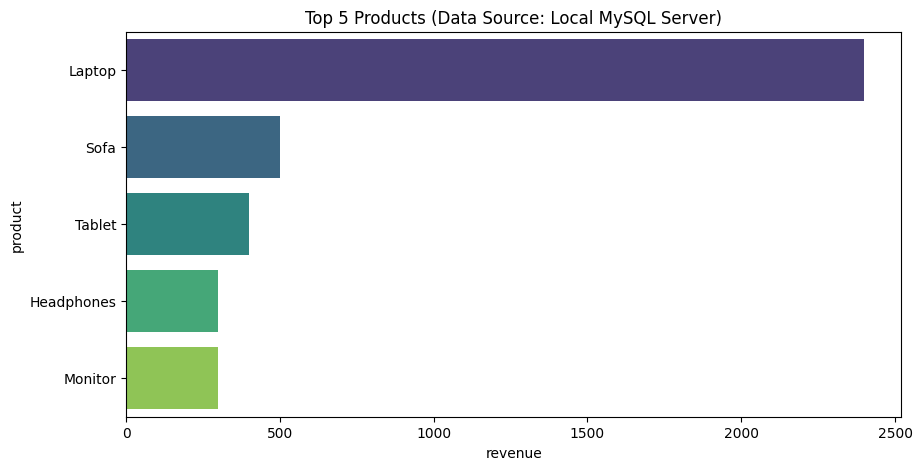

In [ ]:
# --- 6. VISUALIZATION (THE FINAL OUTPUT) ---
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector # Import mysql.connector for the re-establishment logic

# [Step 1: STRATEGIC DATA FETCHING]
# We don't download the whole database to Python.
# We ask SQL to do the heavy lifting (Summing, Sorting, Cutting) first.
# This ensures Python only receives the exact 5 rows it needs to draw the chart.
query_viz = """
SELECT
    product,
    SUM(amount) as revenue
FROM sales
GROUP BY product
ORDER BY revenue DESC
LIMIT 5;                 -- ONLY send the Top 5. Don't clutter the graph.
"""

# --- FIX START: Ensure connection is active ---
# The error "OperationalError: MySQL Connection not available" means the database
# connection ('conn') is no longer valid. This block re-establishes it if needed.

# Check if 'conn' is defined globally and if it's an active connection
if 'conn' not in globals() or conn is None or not conn.is_connected():
    print("Re-establishing MySQL connection for visualization...")
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="sales_db"
        )
    except mysql.connector.Error as err:
        print(f"Error re-establishing connection: {err}")
        # Re-raise the connection error to halt execution gracefully if connection fails
        raise
else:
    print("Connection appears to be active.")
# --- FIX END ---

# [Step 2: THE HANDOFF]
# The result is a tiny, clean DataFrame optimized for plotting.
df_viz = run_query(query_viz)

# [Step 3: RENDER]
# We use Seaborn (built on Matplotlib) to turn the DataFrame into a visual.
# Notice how we map the DataFrame columns ('revenue', 'product') directly to X and Y axes.
plt.figure(figsize=(10, 5))
sns.barplot(data=df_viz, x='revenue', y='product', palette='viridis')

# [Step 4: AESTHETICS]
plt.title('Top 5 Products (Data Source: Local MySQL Server)')
plt.show()
#The Pro Way (This Code): The Database calculates the sum internally and only sends the final 5 rows to Python. It is fast, efficient, and scalable."

In [ ]:
# --- 7. SERVER INTROSPECTION (WHERE ARE WE?) ---
import mysql.connector # Added for connection re-establishment

# [Step 1: SYSTEM VARIABLES]
# In SQL, variables starting with '@@' are Global System Variables.
# We are asking the server 3 specific questions:
# 1. Who are you? (Hostname)
# 2. How do we talk to you? (Port)
# 3. Where do you keep your files? (Data Directory)
query = """
SELECT
    @@hostname as 'Host Name (Container ID)',
    @@port as 'Port',
    @@datadir as 'Storage Location'
"""

# --- FIX START: Ensure connection is active ---
# The error "OperationalError: MySQL Connection not available" means the database
# connection ('conn') is no longer valid. This block re-establishes it if needed.

# Check if 'conn' is defined globally and if it's an active connection
if 'conn' not in globals() or conn is None or not conn.is_connected():
    print("Re-establishing MySQL connection for server introspection...")
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="sales_db"
        )
    except mysql.connector.Error as err:
        print(f"Error re-establishing connection: {err}")
        # Re-raise the connection error to halt execution gracefully if connection fails
        raise
else:
    print("Connection appears to be active.")
# --- FIX END ---

# [Step 2: EXECUTION]
# We run this just like a normal data query.
# The result reveals the physical configuration of our Colab environment.
df_info = pd.read_sql(query, conn)
display(df_info)

Re-establishing MySQL connection for server introspection...


/tmp/ipython-input-188003091.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_info = pd.read_sql(query, conn)


,Host Name (Container ID),Port,Storage Location
0,5dc8c5b569c0,3306,/var/lib/mysql/


In [ ]:
# --- 8. VERIFYING PHYSICAL STORAGE ---

# [Step 1: THE LINUX COMMAND]
# We are stepping out of Python and asking the Operating System (Linux) to show us files.
# !ls  = List Segments (Show me the files)
# -l   = Long Format (Show me details like permissions and owner)
# -h   = Human Readable (Show sizes in KB/MB instead of bytes)
# /var/lib/mysql/ = The default "Home Folder" for MySQL data on Linux systems.

print("--- Listing MySQL Data Directory ---")
!ls -lh /var/lib/mysql/

--- Listing MySQL Data Directory ---
total 90M
-rw-r----- 1 mysql mysql    5 Dec  7 05:53  5dc8c5b569c0.pid
-rw-r----- 1 mysql mysql   56 Dec  7 05:52  auto.cnf
-rw-r----- 1 mysql mysql  180 Dec  7 05:53  binlog.000001
-rw-r----- 1 mysql mysql  404 Dec  7 05:53  binlog.000002
-rw-r----- 1 mysql mysql 2.3K Dec  7 05:53  binlog.000003
-rw-r----- 1 mysql mysql   48 Dec  7 05:53  binlog.index
-rw------- 1 mysql mysql 1.7K Dec  7 05:52  ca-key.pem
-rw-r--r-- 1 mysql mysql 1.1K Dec  7 05:52  ca.pem
-rw-r--r-- 1 mysql mysql 1.1K Dec  7 05:52  client-cert.pem
-rw------- 1 mysql mysql 1.7K Dec  7 05:52  client-key.pem
-rw-r--r-- 1 root  root     0 Dec  7 05:53  debian-5.7.flag
-rw-r----- 1 mysql mysql 192K Dec  7 05:54 '#ib_16384_0.dblwr'
-rw-r----- 1 mysql mysql 8.2M Dec  7 05:52 '#ib_16384_1.dblwr'
-rw-r----- 1 mysql mysql 3.4K Dec  7 05:53  ib_buffer_pool
-rw-r----- 1 mysql mysql  12M Dec  7 05:54  ibdata1
-rw-r----- 1 mysql mysql  12M Dec  7 05:53  ibtmp1
drwxr-x--- 2 mysql mysql 4.0K Dec  

In [ ]:
# --- 9. INSPECTING TABLE FILES ---

# [Step 1: THE TARGET FOLDER]
# We are now looking inside the specific sub-folder for 'sales_db'.
# In MySQL, every CREATE DATABASE command makes a new folder.
# Every CREATE TABLE command makes a new file inside that folder.

print("--- Contents of 'sales_db' Database ---")
!ls -lh /var/lib/mysql/sales_db/

--- Contents of 'sales_db' Database ---
total 112K
-rw-r----- 1 mysql mysql 112K Dec  7 05:53 sales.ibd
